The first step was preparing the data. I gathered images of letters in gurmukhi by using various fonts and the omniglot dataset for gurmukhi. These images were cropped and resized into 40x40 pngs with a bit depth of 1. Each image was then used to create 9 more images by changing the image zoom and using different translations.

3 different folders were made, a training set, cross validation set and an evaluation set. Each folder had 35 subfolders, one for each letter. The training set had about 70% of the images while the other two sets had 15% each.

In [1]:
import os, sys, numpy
from PIL import Image

# returns m x n matrix, m is number of pictures and n is (height x width), each image is its own row vector
# also returns y an m x 1 column vector, an integer from 1-35 labelling the picture
def ReadImagesIntoMatrix(dir):
    
    matrix = numpy.zeros(0)
    
    label = int(''.join(filter(str.isdigit, dir)))
            
    for filename in os.listdir(dir):
        img = Image.open(dir + "/" + filename)
        arr = numpy.array(img).ravel().astype(int)

        if(matrix.size == 0):
            matrix = arr
            y = label
        else:
            matrix = numpy.row_stack((matrix, arr))
            y = numpy.row_stack((y, label))
    return matrix, y;

In [2]:
TrainingSetDirectory = (os.path.dirname(os.path.abspath("Notebook.ipynb"))) + "\TrainingSets"
CVSetDirectory = (os.path.dirname(os.path.abspath("Notebook.ipynb"))) + "\TestSets\CrossValidationSets"
TestSetDirectory = (os.path.dirname(os.path.abspath("Notebook.ipynb"))) + "\TestSets\EvaluationSets"

In [3]:
X_TRAIN = numpy.zeros(0)
Y_TRAIN = numpy.zeros(0)
X_CV = numpy.zeros(0)
Y_CV = numpy.zeros(0)
X_TEST = numpy.zeros(0)
Y_TEST = numpy.zeros(0)

for subdir, dirs, files in os.walk(TrainingSetDirectory):
    for dir in dirs:
        
        matrix, labels = ReadImagesIntoMatrix(TrainingSetDirectory + "\\" + dir)
        if(X_TRAIN.size == 0):
            X_TRAIN = matrix;
            Y_TRAIN = labels;
        else:
            X_TRAIN = numpy.row_stack((X_TRAIN, matrix))
            Y_TRAIN = numpy.row_stack((Y_TRAIN, labels))
            
for subdir, dirs, files in os.walk(CVSetDirectory):
    for dir in dirs:
        
        matrix, labels = ReadImagesIntoMatrix(CVSetDirectory + "\\" + dir)
        if(X_CV.size == 0):
            X_CV = matrix;
            Y_CV = labels;
        else:
            X_CV = numpy.row_stack((X_CV, matrix))
            Y_CV = numpy.row_stack((Y_CV, labels))
            
for subdir, dirs, files in os.walk(TestSetDirectory):
    for dir in dirs:
        
        matrix, labels = ReadImagesIntoMatrix(TestSetDirectory + "\\" + dir)
        if(X_TEST.size == 0):
            X_TEST = matrix;
            Y_TEST = labels;
        else:
            X_TEST = numpy.row_stack((X_TEST, matrix))
            Y_TEST = numpy.row_stack((Y_TEST, labels))

In [4]:
def LabelToVector(Labels):
    vectors = numpy.zeros(35)  
    vectors[Labels[0]-1] = 1
    
    if(len(Labels) == 1):
        return vectors    
    
    for i in range(1, len(Labels)):
        nextRow = numpy.zeros(35) 
        nextRow[Labels[i]-1] = 1
        vectors = numpy.row_stack((vectors, nextRow))
    
    return numpy.array(vectors)

def VectorToLabel(Vectors):
    labels = []
    for i in range(len(Vectors)):
        vector = Vectors[i,:]
        maxIndex = 0;
        for j in range(len(vector)):
            if(vector[j] > vector[maxIndex]):
                maxIndex = j
        labels.append(maxIndex+1)
    return labels

In [5]:
Y_TRAIN = LabelToVector(Y_TRAIN)
Y_CV = LabelToVector(Y_CV)
Y_TEST = LabelToVector(Y_TEST)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
pca.fit(X_TRAIN) 

X_TRAIN_pca = pca.transform(X_TRAIN) 
X_CV_pca = pca.transform(X_CV)
X_TEST_pca = pca.transform(X_TEST)

In [7]:
print("The percent variance is", numpy.sum(pca.explained_variance_ratio_) * 100)
newX = pca.inverse_transform(X_TRAIN_pca);

The percent variance is 90.86981537610048


In [8]:
import matplotlib.pyplot as plt
import math 
def ViewImage(ImgVector):
    height_and_width = int(math.sqrt(ImgVector.size))
    img = numpy.reshape(ImgVector, (height_and_width,height_and_width))
    plt.imshow(img);

Before PCA is applied


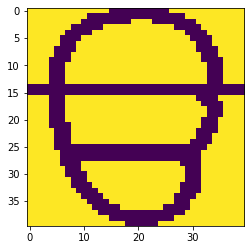

In [9]:
print("Before PCA is applied")
ViewImage(X_TRAIN[0,:])

After PCA is applied


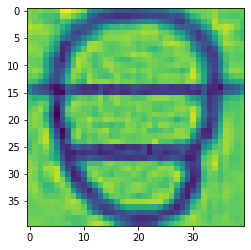

In [10]:
print("After PCA is applied")
ViewImage(newX[0,:])

In [11]:
# Variables that describe the neural net itself 

INPUT_LAYER_UNITS = 300 # notice this number is the same as n_components
HIDDEN_LAYER_UNITS = 200 # This value was found to be good at balancing performance, while also preventing overfitting or having the network memorize the inputs

OUTPUT_LAYER_UNITS = 35 # there are 35 letters in the gurmukhi alphabet

#randomly initialize theta1 and theta2 withs weights over [-0.125, 0.125)
theta1 = numpy.random.rand(HIDDEN_LAYER_UNITS, INPUT_LAYER_UNITS + 1)/4 - 0.125
theta2 = numpy.random.rand(OUTPUT_LAYER_UNITS, HIDDEN_LAYER_UNITS + 1)/4 - 0.125

In [12]:
# returns m x 35 matrix
def forwardPropagate(X, theta1, theta2):
    # add x0 = 1 column
    to_insert = numpy.ones(len(X))
    a1 = numpy.insert(X, 0, to_insert, axis = 1)
    z2 = numpy.dot(a1, theta1.transpose())
    a2 = sigmoid(z2)
    
    to_insert = numpy.ones(len(a2))
    a2 = numpy.insert(a2, 0, to_insert, axis = 1)
    z3 = numpy.dot(a2, theta2.transpose())
    a3 = sigmoid(z3)
    return a3

![From Stanford's Coursera machine learning course](https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w5_neural_networks_learning/forwardpropagation.png)

In [13]:
def costFunction(X, y, theta1, theta2, reg_parameter):
    
    # m x 35 matrix
    hypothesis = forwardPropagate(X, theta1, theta2);
    firstterm = numpy.sum(numpy.multiply(numpy.log(hypothesis), y) +  numpy.multiply(numpy.log(numpy.subtract(1,hypothesis)), numpy.subtract(1,y))) / len(X)
    secondterm = (numpy.sum(numpy.square(theta1)) - numpy.sum(numpy.square(theta1[:,0])) + numpy.sum(numpy.square(theta2)) - numpy.sum(numpy.square(theta2[:,0]))) * reg_parameter / (2 * len(X))
    return -1 * (firstterm) + secondterm

![cost function for neural net](https://dirtysalt.github.io/html/images/neural-network-cost-function.png)

In [14]:
def sigmoid(matrix):
    return numpy.divide(1,numpy.add(1,numpy.exp(numpy.multiply(-1,matrix))))  

![sigmoid function](https://miro.medium.com/max/970/1*Xu7B5y9gp0iL5ooBj7LtWw.png)

In [15]:
# return (accumulated) gradient for theta1, theta2
def partialDerivative(X, Y, theta1, theta2, reg_parameter):
         
    theta1_grad = numpy.zeros(theta1.shape)
    theta2_grad = numpy.zeros(theta2.shape)
    
    m = len(X)
    
    for i in range(m):
        x = X[i,:]
        y = Y[i,:]
        # add x0
        a1 = numpy.insert(x, 0, 1)
        z2 = numpy.dot(a1, theta1.transpose())
        a2 = sigmoid(z2)
        
        a2 = numpy.insert(a2, 0, 1)
        z3 = numpy.dot(a2, theta2.transpose())
        a3 = sigmoid(z3)
        
        s3 = a3 - y;

        s2 = numpy.multiply(numpy.dot(theta2.transpose(), s3.transpose()), numpy.multiply(a2, (1-a2)))
        # remove first term
        s2 = numpy.delete(s2,0)
       
        theta1_grad = theta1_grad + numpy.outer(s2, a1)
        theta2_grad = theta2_grad + numpy.outer(s3, a2)
   
   
    selector1 = [x for x in range(theta1.shape[1]) if x != 0]
    selector2 = [x for x in range(theta2.shape[1]) if x != 0]        
    theta1_grad = (theta1_grad + (numpy.append(numpy.zeros((len(theta1), 1)) , theta1[:,selector1], axis = 1)) * reg_parameter) / m;
    theta2_grad = (theta2_grad + (numpy.append(numpy.zeros((len(theta2), 1)) , theta2[:,selector2], axis = 1)) * reg_parameter) / m;
    
    return theta1_grad, theta2_grad

![Backpropagation, computing error (Coursera machine learning)](https://i.redd.it/3hki8lsuu0oz.png)

![Backpropagation algorithm (Coursera machine learning)](https://i.stack.imgur.com/uzShq.jpg)

In [16]:
def gradientCheck(X, Y, theta1, theta2, reg_parameter):
    
    theta1_grad = numpy.zeros(theta1.shape)
    theta2_grad = numpy.zeros(theta2.shape)
    
    epsilon = 1e-4
    
    for i in range(len(theta1)):
        for j in range(len(theta1[i,:])):
            newtheta1plus = numpy.copy(theta1)
            newtheta1minus = numpy.copy(theta1)
            newtheta1plus[i,j] = theta1[i,j] + epsilon
            newtheta1minus[i,j] = theta1[i,j] - epsilon
            theta1_grad[i,j] = (costFunction(X,Y,newtheta1plus, theta2, reg_parameter) - costFunction(X,Y,newtheta1minus, theta2, reg_parameter)) / (2 * epsilon)
              
    for i in range(len(theta2)):
        for j in range(len(theta2[i,:])):
            newtheta2plus = numpy.copy(theta2)
            newtheta2minus = numpy.copy(theta2)
            newtheta2plus[i,j] = theta2[i,j] + epsilon
            newtheta2minus[i,j] = theta2[i,j] - epsilon
            theta2_grad[i,j] = (costFunction(X,Y,theta1, newtheta2plus, reg_parameter) - costFunction(X,Y,theta1, newtheta2minus, reg_parameter)) / (2 * epsilon)
 
    return theta1_grad, theta2_grad

![Gradient Checking logic](https://i.ytimg.com/vi/u33GlS8IJws/hqdefault.jpg)

In [ ]:
theta1a, theta2a = partialDerivative(X_TRAIN_pca, Y_TRAIN, theta1, theta2, 1) # set regularization parameter to 1
theta1b, theta2b = gradientCheck(X_TRAIN_pca, Y_TRAIN, theta1, theta2, 1) # will take very long to run, to prove that this works set the hyperparameters to smaller values for this
print(numpy.max(numpy.absolute(theta1a-theta1b))) # should be very small(maybe around 1e-9)
print(numpy.max(numpy.absolute(theta2a-theta2b))) # should be very small(maybe around 1e-9)

In [17]:
def performGradientDescent(X, Y, X_CV, Y_CV, theta1, theta2, reg_parameter, learning_rate, iterations):
    
    plt.axis([0, iterations, 0, 30])
    
    xaxis = []
    yaxis = []
    yaxis2 = []
    

    for step in range(iterations):
        theta1_grad, theta2_grad = partialDerivative(X, Y, theta1, theta2, reg_parameter)
        theta1 = theta1 - learning_rate * theta1_grad
        theta2 = theta2 - learning_rate * theta2_grad
        cost = costFunction(X, Y, theta1, theta2, 0)
        TestCost =  costFunction(X_CV, Y_CV, theta1, theta2, 0)
        
        xaxis.append(step)
        yaxis.append(cost)
        yaxis2.append(TestCost)
        print(step)
        print(cost)
        print(TestCost)
        
    plt.plot(xaxis,yaxis)
    plt.plot(xaxis,yaxis2)
    print(yaxis[-1])
    print(yaxis2[-1])
    
    return theta1, theta2


In [ ]:
trained_theta1, trained_theta2 = performGradientDescent(X_TRAIN_pca, Y_TRAIN, X_CV_pca, Y_CV, theta1, theta2, 5, 1, 10000)
hypothesis_set = forwardPropagate(X_TEST_pca, trained_theta1, trained_theta2)
def checkCorrect(predictions, actual):
    correct = 0
    num = 0
    for i in range(len(predictions)):
        num = num+1
        if predictions[i] == actual[i]:
            correct+=1
    return correct / num

print("Percent of test set predicted correctly is", checkCorrect(VectorToLabel(hypothesis_set), VectorToLabel(Y_TEST)) * 100)

The following is pretrained model with 300 input units and 200 hidden layer units. There definitely exists a set of parameters theta1 and theta2 with better accuracy. I faced limitations because of slow training that hindered my ability to test a number of different combinations of the number of input units, hidden layer units, hidden layers, and the regularization parameter.

In [19]:
trained_theta1 = numpy.load("theta1.npy")
trained_theta2 = numpy.load("theta2.npy")
hypothesis_set = forwardPropagate(X_TEST_pca, trained_theta1, trained_theta2)
def checkCorrect(predictions, actual):
    correct = 0
    num = 0
    for i in range(len(predictions)):
        num = num+1
        if predictions[i] == actual[i]:
            correct+=1
    return correct / num

print("Percent of test set predicted correctly is", checkCorrect(VectorToLabel(hypothesis_set), VectorToLabel(Y_TEST)) * 100)

Percent of test set predicted correctly is 77.77365491651206


Even if the model incorrectly labels a character, the model isn't useless. For each picture, each character is given a probability of the image being that character. With the example of getting a model to predict what word is in a picture, perhaps an n-gram model can be used with this neural network to recognize the words.

For whatever application this model is used, more data is needed with respect to that application. The test data is admittedly very similar to the training data because of the lack of overall data.